# Neural Network Prediction of Sahelian Summer Rainfall
***

#### Resources:
* [Mardata Course](https://github.com/mardatade/Course-Python-for-Machine-Learning/blob/master/3.%20Neural%20Network.ipynb)
* [Keras for Data Scientists](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing)

In [1]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.utils import shuffle
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

<br>
<br>

## 1. Data Loading & Preprocessing
***

<br>

### a) Loading & Normalization

**pred:** contains the data used for the inputs  <br>
**label:** from Sahelrainfall data serves as validation data

In [2]:
pred = xr.open_dataset('data/da_pred_all.nc').to_dataframe()

pred_unit = pd.DataFrame(
    data = StandardScaler().fit_transform(pred), 
    columns = pred.columns,
    index =  pred.index
)


# load validatoin data (Summer Rainfall over Sahel) 
labels = np.mean(np.loadtxt("data/da_o_sahelprecip19012017.txt", skiprows=8,)[:,7:10] * 0.01,  axis=1)

labels = np.squeeze(StandardScaler().fit_transform(np.reshape(labels, (117,1))))


In [3]:
labels.std()

0.9999999999999999

In [4]:
pred_unit.head()

,siod_e,siod_w,sst_med,tsa,tna,sst_mdr,sata_lnh,sata_lsh,sata_onh,sata_osh,slp_darwin,slp_tahiti,amo,nao,pdo,np,nino12,nino3,nino34,nino4
year,,,,,,,,,,,,,,,,,,,,
1901,-1.100027,-1.152764,-0.745530,-0.595366,0.388372,0.608415,-0.123443,-0.732091,-0.497808,-0.737797,0.074807,1.634819,0.923204,0.917456,-0.193321,1.938388,-0.950168,-0.595561,-0.214314,-0.079270
1902,0.088643,0.340415,-1.507314,-0.954566,-0.346586,-0.173588,-1.289978,-0.201810,-1.175314,-0.987096,1.443896,2.682485,-0.620146,-1.172590,0.819716,-0.162154,0.991321,0.969845,1.099218,1.070532
1903,-0.900789,0.669332,-2.243639,-2.186294,-0.101970,0.283583,-1.333183,-1.076056,-1.415719,-1.333946,-0.071881,1.535042,-0.458290,-1.030410,-0.186187,0.530864,-0.371251,0.000784,0.524139,0.842095
1904,-0.949568,-1.056219,-0.079925,-1.975498,-2.214111,-1.894743,-1.135674,-1.133384,-1.863746,-1.778347,-0.903114,1.235708,-1.872482,1.447076,-0.892459,0.756497,-0.307712,-0.234313,-0.475713,-0.741738
1905,-0.034350,-0.632249,-0.718895,-1.684676,-1.334312,-1.014906,-1.314666,-0.595938,-1.284589,-0.954579,0.759351,-2.655622,-0.499163,-1.289888,0.545055,-0.326007,1.227830,1.497381,1.439037,1.032459


<br>

### b) PCA

### **Question:** normalize pcs again? --> See : [Data loading & preprocessing](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing) 
variance is non-unit for now...\
or does another normalization clear out the information of the pcs?
Badr did not mention anything like that.

In [5]:
# Scikit pca transformation
pca = PCA()
principalComponents = pca.fit_transform(pred_unit)


# Create Create Pandas DF from PCs
col = []
for i in range(1, 21):
    col.append(f'PC{i}')

pred_pc = pd.DataFrame(
    data = principalComponents,
    columns = col,
    index =  pred.index
)

pred_pc = pd.DataFrame(
    data = StandardScaler().fit_transform(pred_pc), 
    columns = pred_pc.columns,
    index =  pred_pc.index
)

# Test for unit-variance and zero mean:
print(np.std(pred_pc))
print(np.mean(pred_pc))
# pred_pc.head()

PC1     1.0
PC2     1.0
PC3     1.0
PC4     1.0
PC5     1.0
PC6     1.0
PC7     1.0
PC8     1.0
PC9     1.0
PC10    1.0
PC11    1.0
PC12    1.0
PC13    1.0
PC14    1.0
PC15    1.0
PC16    1.0
PC17    1.0
PC18    1.0
PC19    1.0
PC20    1.0
dtype: float64
PC1     1.973730e-16
PC2     3.510962e-17
PC3     5.930679e-17
PC4    -2.846726e-18
PC5     4.744543e-19
PC6    -3.795634e-17
PC7     3.795634e-18
PC8    -2.324826e-17
PC9     6.642360e-17
PC10   -1.470808e-17
PC11   -2.656944e-17
PC12   -1.138690e-17
PC13    1.550872e-17
PC14   -1.518254e-17
PC15    1.138690e-17
PC16    1.423363e-17
PC17    2.182490e-17
PC18   -3.705562e-17
PC19   -1.613145e-17
PC20   -1.802926e-17
dtype: float64


<br>

### c) Select PCs for input and turn into numpy array

In [6]:
features = pred_pc.loc[:,['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].to_numpy()
features.shape

(117, 5)

<br>
<br>

## 2. Build Model
***

### **Question:** Badr says in Table2: '**standard* correlation and error meassures'? --> means standard or standardized?

<br>

## a) RRHCV


### 1.) Define Model

In [7]:
def Buildmodel(HPARAMS):
    model = keras.Sequential([
#         layers.Dropout(0.1, input_shape=(20,)),
        layers.Dense(64, HPARAMS['activation'] ,name="layer1"),
        layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer1"),
        
        layers.Dense(16, HPARAMS['activation'], name="layer2"),
        layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer2"),
        
        layers.Dense(8, HPARAMS['activation'], name="layer3"),
        layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer3"),
        
        layers.Dense(4, HPARAMS['activation'], name="layer4"),
        layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer4"),
        
#         layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer5"),
#         layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer5"),
        
#         layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer6"),
#         layers.Dropout(HPARAMS['dropout_rate'] ,name="Dropout_layer6"),
        
        layers.Dense(1,  name='output'), #activation='linear'
    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(
            learning_rate=HPARAMS['learn_rate']
        )
    )
    return model

<br>

### 2.) Train model
* Perfrom in total k Repetitions
* For each walkthrough the data is first shuffled and the split into training (90%) and test (10%) sets.
* save single error metrics () into numpy array 
* **set parameters at top of cell**

In [8]:
### choose parameters ###
HPARAMS = {
    'activation': 'relu',
    'optimizer': 'Adam',
    'learn_rate': 0.001,
    'batch_size': 20,
    'n_epochs': 200,
    'dropout_rate': 0.05,
    'layersize': 2,
    
}

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)



k = 5 # number of 'folds' -> sample size as in Badr
# test_frac = .1 # factrion that is held out for testing

In [9]:
%%time

# define error metrics:
mae_train = []
mad_train = []
mse_train = []
rmse_train = []
corr_train = []

mae_test = []
mad_test = []
mse_test = []
rmse_test = []
corr_test = []

training_length = []

# use sklearn Shuffle Split to Lood through Cross-Validation
# for train_index, test_index in ShuffleSplit(n_splits=k, test_size=test_frac).split(features):      #RRHCV
for train_index, test_index in KFold(n_splits=k, shuffle=True).split(features):                      #KFold

    train_index = shuffle(train_index)
    test_index  = shuffle(test_index)
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    # Build the model according to definition:
    model = Buildmodel(HPARAMS)
    

    #Train the model 
    train_history = model.fit(
        features[train_index],
        labels[train_index],
        batch_size=HPARAMS['batch_size'],
        epochs=HPARAMS['n_epochs'],
        verbose=0,
        callbacks=earlystop
    )

    
    #Run the model for insample data:
    y_train= np.squeeze(model.predict(features[train_index]))
    
    # ... and for out of sample data
    y_test = np.squeeze(model.predict(features[test_index]))
    
    
    # save errors into numpy arrays:
    e_train =  y_train - labels[train_index]
    ae_train = np.absolute(e_train)
    mae_train = np.append(mae_train, np.mean(ae_train))
    mad_train = np.append(mad_train, np.median(np.absolute(e_train - np.median(e_train))))
    mse_train = np.append(mse_train, np.mean(e_train**2))
    rmse_train = np.append(rmse_train, np.sqrt(mse_train))
    corr_train = np.append(corr_train, st.pearsonr(y_train, labels[train_index])[0])
    
    
    e_test =  y_test - labels[test_index]
    ae_test = np.absolute(e_test)
    mae_test = np.append(mae_test, np.mean(ae_test))
    mad_test = np.append(mad_test, np.median(np.absolute(e_test - np.median(e_test))))
    mse_test = np.append(mse_test, np.mean(e_test**2))
    rmse_test = np.append(rmse_test, np.sqrt(mse_test))
    corr_test = np.append(corr_test, st.pearsonr(y_test, labels[test_index])[0])
    
    training_length = np.append(training_length, len(train_history.history['loss']))

TRAIN: [ 56   7 109  80   8  75 108  89  23  82 103  12  28  55  42  15  88  97
  13  91  74  36  94 116  66  24  53  20 100  68  51  96  73  40  93  49
  84  83 101  92  45  33  70  62   4  64   5  48  10 104  86  47  43  32
  16  29   6  17 111  98   9 115   3  21  41  69  25  37  58  59  87  52
  44  27  99  78  77 110 114  90 113  38  65   2  34 107  18   0  31  14
  30 105  72] TEST: [ 95  50  61  11  67  63  35 106  81  79  76  60  54  71  46  57 112  22
 102  39  85  26  19   1]
TRAIN: [ 48  71   9   0 101  75  56  79  30  15  86  29   7 104  87  94  60 106
  95   5  35   6  74  70 109  38  49  26  44  37  61  92  13 108  69  52
 113  50   8  57  99  32  34  53  72 107  24  83  76  54  64  81  77  97
  12  40  16  85  39 112  31  11   2  63  20 102 115  88  25 111  55  91
  22  46  21 100 110  43  67  10 103  19   1  66  78  27  65  51  80  33
  41  58 114] TEST: [105  93  84  89  36  28  18  42  62  17  47  23  59  45   4  98  14   3
  82 116  96  90  68  73]
TRAIN: [  8  98 11

In [10]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                384       
_________________________________________________________________
Dropout_layer1 (Dropout)     (None, 64)                0         
_________________________________________________________________
layer2 (Dense)               (None, 16)                1040      
_________________________________________________________________
Dropout_layer2 (Dropout)     (None, 16)                0         
_________________________________________________________________
layer3 (Dense)               (None, 8)                 136       
_________________________________________________________________
Dropout_layer3 (Dropout)     (None, 8)                 0         
_________________________________________________________________
layer4 (Dense)               (None, 4)                

In [11]:
corr_train

array([0.55425649, 0.55764696, 0.24690347, 0.62060135, 0.53893923])

In [12]:
corr_test

array([ 0.53904548,  0.46148883, -0.11357425,  0.55641464,  0.2655327 ])

In [13]:
mse_train

array([0.81560669, 0.84380877, 0.9913976 , 0.83553812, 0.86648315])

In [14]:
mse_test

array([0.89801991, 0.73661587, 0.98147755, 1.03945853, 0.92765019])

In [15]:
train_history

<br>

### 3.) Error Computation

#### Training Errors

In [16]:
train_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.nanmean(corr_train)],
        'corr_sig': [np.std(corr_train)],
        'mad_mu': [np.mean(mad_train)],
        'mad_sig': [np.std(mad_train)],
        'mae_mu': [np.mean(mae_train)],
        'mae_sig': [np.std(mae_train)],
        'mse_mu': [np.mean(mse_train)],
        'mse_sig': [np.std(mse_train)],
        'rmse_mu': [np.mean(rmse_train)],
        'rmse_sig': [np.std(rmse_train)],
        'training_length_mu': [np.mean(training_length)],
        'training_length_sig': [np.std(training_length)],
    }
)
train_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig,training_length_mu,training_length_sig
0,0.503669,0.131391,0.686687,0.050843,0.771139,0.033234,0.870567,0.062579,0.929066,0.034231,9.6,4.317407


<br>

#### Test Errors

In [17]:
test_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_test)],
        'corr_sig': [np.std(corr_test)],
        'mad_mu': [np.mean(mad_test)],
        'mad_sig': [np.std(mad_test)],
        'mae_mu': [np.mean(mae_test)],
        'mae_sig': [np.std(mae_test)],
        'mse_mu': [np.mean(mse_test)],
        'mse_sig': [np.std(mse_test)],
        'rmse_mu': [np.mean(rmse_test)],
        'rmse_sig': [np.std(rmse_test)],
    }
)
test_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.341781,0.249989,0.557374,0.066001,0.784691,0.053283,0.916644,0.102142,0.943037,0.056436


<br>

### 4.) PLot model output vs Validation Data

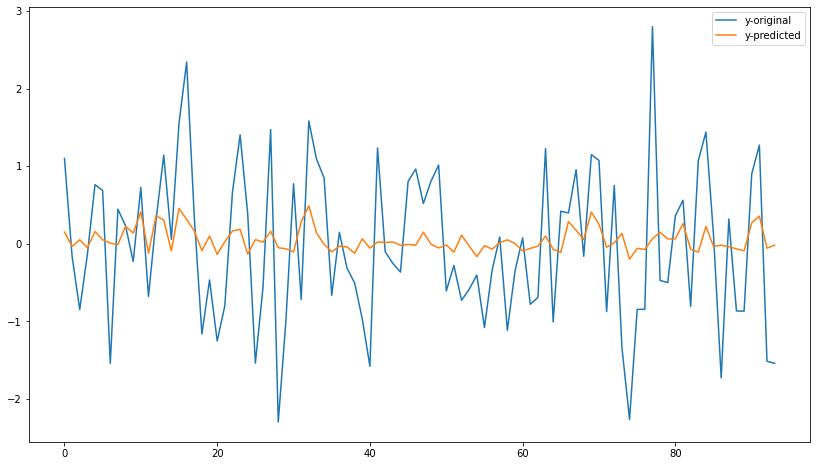

In [18]:
plt.figure(figsize=(14,8))
plt.plot(labels[train_index], label="y-original")
plt.plot(y_train, label="y-predicted")
plt.legend()
plt.show()

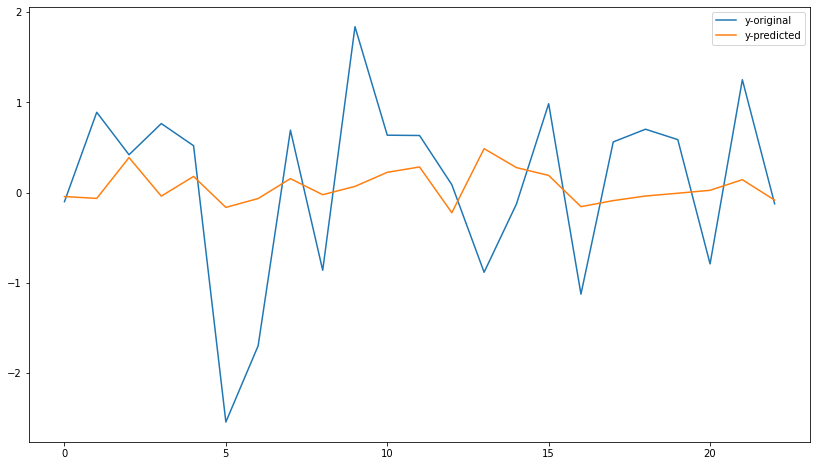

In [19]:
plt.figure(figsize=(14,8))
plt.plot(labels[test_index], label="y-original")
plt.plot(y_test, label="y-predicted")
plt.legend()
plt.show()

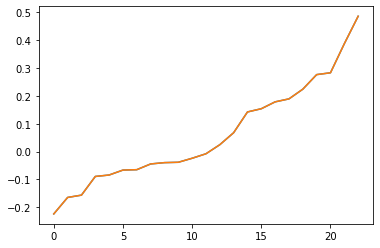

In [20]:
plt.plot(np.sort(y_test))
plt.plot(np.sort(np.squeeze(model.predict(features[test_index]))))

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                384       
_________________________________________________________________
Dropout_layer1 (Dropout)     (None, 64)                0         
_________________________________________________________________
layer2 (Dense)               (None, 16)                1040      
_________________________________________________________________
Dropout_layer2 (Dropout)     (None, 16)                0         
_________________________________________________________________
layer3 (Dense)               (None, 8)                 136       
_________________________________________________________________
Dropout_layer3 (Dropout)     (None, 8)                 0         
_________________________________________________________________
layer4 (Dense)               (None, 4)                

In [22]:
features.shape

(117, 5)

In [23]:
model.get_weights()

[array([[ 2.13897690e-01, -2.16759905e-01,  8.28825496e-03,
         -9.90205854e-02,  1.66096866e-01, -4.90444824e-02,
          1.77695513e-01, -7.62241632e-02,  1.15694694e-01,
          2.00720549e-01, -5.24142608e-02,  6.23246096e-02,
          5.10867909e-02, -4.39675711e-02, -4.82094884e-02,
         -2.49754772e-01, -1.77810892e-01, -5.86116277e-02,
         -1.23716168e-01, -2.45636418e-01, -7.91474730e-02,
         -6.24811649e-02,  2.82381147e-01,  4.46528792e-02,
         -1.47207335e-01, -1.44024581e-01,  1.26995474e-01,
          6.54788688e-02, -5.29613532e-02,  2.96853911e-02,
         -2.23597899e-01,  1.89323187e-01, -1.42313778e-01,
          1.42103627e-01,  2.50162989e-01, -2.63920993e-01,
          1.35859489e-01, -2.53643602e-01, -1.26304924e-01,
         -5.68036400e-02, -1.30811647e-01,  1.37614891e-01,
         -2.07114205e-01,  5.10047451e-02,  2.85718501e-01,
         -7.91581441e-03,  2.96715021e-01,  2.77939498e-01,
         -1.63921967e-01,  1.97121963e-0

In [24]:
w_all = [layer.get_weights() for layer in model.layers[::-1] if not 'Drop' in layer.name]

a_all = [keras.backend.function([model.input],[layer.output])(features[44:45]) for layer in model.layers[::-1] if not 'Drop' in layer.name]
a_all.append([features[44:45]])

In [29]:
R = [np.squeeze(a_all[0])]

for lay in range( len(w_all)):
    
    w_jk = w_all[lay]                       # [weights, bias] | weights_shape = (lowerlayer, currentlayer)
    a_j  = np.squeeze(a_all[lay+1]).T       # activation lower layer | shape = (node/input, sample) samp: -> to be handled via loop dot() difficulties
    
    z_k = a_j.dot(w_jk[0]) + w_jk[1]        #Step 1: for all k -> dotproduct along 1st dim (lowerlayer)
    s_k = R[lay] / (z_k + 1e-9)             #Step 2: for all k -> element-wise operation
    c_j = s_k.dot(w_jk[0].T)                #Step 3: for all j -> dotproduct along 2nd dim (currentlayer)
    R.append(a_j * c_j)                     #STep 4: for all j -> element-wise operation

In [30]:
R

[array(0.18747345, dtype=float32),
 array([ 0.        ,  0.20481214, -0.        , -0.        ], dtype=float32),
 array([ 0.        ,  0.06669273, -0.        ,  0.        ,  0.06681256,
        -0.        , -0.00949673,  0.09636371], dtype=float32),
 array([-0.00760941,  0.        ,  0.05475625,  0.02552941,  0.10445105,
        -0.        , -0.        , -0.03820063, -0.07665475, -0.        ,
         0.06135001, -0.        ,  0.        ,  0.        ,  0.10719582,
         0.        ], dtype=float32),
 array([ 0.13525803,  0.        , -0.03307898,  0.0809067 , -0.00490854,
         0.        ,  0.        , -0.        , -0.        ,  0.        ,
        -0.05137784, -0.        ,  0.        , -0.        ,  0.02193714,
         0.        ,  0.06130574,  0.03594927, -0.00359643, -0.00040218,
        -0.        , -0.00026881, -0.01102195, -0.03976471, -0.08413622,
         0.006801  ,  0.00470243,  0.        ,  0.0041475 , -0.        ,
         0.        , -0.01853359,  0.01805667,  0.050830

In [31]:
[l.sum() for l in R]

[0.18747345,
 0.20481214,
 0.22037226,
 0.23081776,
 0.22824536,
 0.2143303808105773]

In [32]:
w = [np.absolute(item).sum() for items in w_all for item in items][1::2]
w

[0.017338695, 0.06600772, 0.094910465, 0.1338796, 0.58238846]

In [35]:
np.absolute(w_all[1][1])

array([0.01728352, 0.01549186, 0.01666419, 0.01656815], dtype=float32)

In [357]:
R = [np.squeeze(a_all[0])]
R

[array(0.10011413, dtype=float32)]

In [332]:
lay = 0
w_jk = w_all[lay] 
w_jk

[array([[ 0.1089761],
        [-0.1247712]], dtype=float32),
 array([-0.09073978], dtype=float32)]

In [334]:
a_j  = np.squeeze(a_all[lay+1]).T 
a_j

array([1.7513374, 0.       ], dtype=float32)

In [335]:
z_k = a_j.dot(w_jk[0]) + w_jk[1]
z_k

array([0.10011413], dtype=float32)

In [336]:
s_k = R[lay] / (z_k + 1e-9)
s_k

array([1.], dtype=float32)

In [355]:
c_j = s_k.dot(np.concatenate((w_jk[0], w_jk[1].reshape((1, 1)))).T)
c_j

array([ 0.1089761 , -0.1247712 , -0.09073978], dtype=float32)

In [356]:
a_j * c_j

ValueError: operands could not be broadcast together with shapes (2,) (3,) 